In [1]:
"""
UHID Essex County - Intervention Simulation & Cost-Benefit Analysis

Team Members:
- Samuel
- Rohith Reddy Gade
- Siva Prakash Reddy Rachapalli
- Sai Charan Kumar Reddy Boggula

Institution: Montclair State University
Date: November 2025
Purpose: Simulate cooling interventions and calculate cost-effectiveness

This notebook:
1. Loads regression model from previous analysis
2. Defines intervention scenarios (trees, cool roofs, cool pavement)
3. Simulates temperature changes
4. Calculates costs and benefits
5. Identifies priority intervention areas
6. Creates before/after visualizations
"""

'\nUHID Essex County - Intervention Simulation & Cost-Benefit Analysis\n\nTeam Members:\n- Samuel\n- Rohith Reddy Gade\n- Siva Prakash Reddy Rachapalli\n- Sai Charan Kumar Reddy Boggula\n\nInstitution: Montclair State University\nDate: November 2025\nPurpose: Simulate cooling interventions and calculate cost-effectiveness\n\nThis notebook:\n1. Loads regression model from previous analysis\n2. Defines intervention scenarios (trees, cool roofs, cool pavement)\n3. Simulates temperature changes\n4. Calculates costs and benefits\n5. Identifies priority intervention areas\n6. Creates before/after visualizations\n'

In [4]:
# ============================================
# SETUP
# ============================================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/SharedFilesUHIDTeam')

print("✓ Drive mounted")
print("\nUHID Essex County - Intervention Simulation")
print("Team: Samuel Quansah, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,")
print("      Sai Charan Kumar Reddy Boggula")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Drive mounted

UHID Essex County - Intervention Simulation
Team: Samuel Quansah, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,
      Sai Charan Kumar Reddy Boggula


In [3]:
# ============================================
# INSTALL & IMPORT LIBRARIES
# ============================================
print("\n=== Installing Packages ===")
!pip install rasterio geopandas matplotlib seaborn -q

import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Packages loaded")


=== Installing Packages ===
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 77.9 MB/s eta 0:00:00
✓ Packages loaded


In [5]:
# ============================================
# STEP 1: LOAD MODEL COEFFICIENTS
# ============================================
print("\n=== Loading Model Coefficients ===")

model_coef_file = Path('07_Modeling_Results/Model_Coefficients.csv')

if model_coef_file.exists():
    model_coef = pd.read_csv(model_coef_file)
    print("✓ Model coefficients loaded")
    print("\n", model_coef)

    # Extract coefficients
    coef_dict = dict(zip(model_coef['Variable'], model_coef['Coefficient']))

    print("\n📊 Temperature Change per 1% Change:")
    for var, coef in coef_dict.items():
        print(f"  {var}: {coef:+.4f}°C")
else:
    print("⚠️ Model coefficients not found!")
    print("Using typical values from literature:")
    coef_dict = {
        'Impervious_Pct': 0.15,      # Positive: more impervious = hotter
        'TreeCanopy_Pct': -0.12,     # Negative: more trees = cooler
        'Traffic_Density': 0.0001    # Small positive effect
    }



=== Loading Model Coefficients ===
✓ Model coefficients loaded

           Variable  Coefficient  Std_Error        P_value  RF_Importance
0   Impervious_Pct     0.080908   0.002173  1.649428e-279       0.719572
1   TreeCanopy_Pct     0.004357   0.000992   1.145029e-05       0.251461
2  Traffic_Density    -0.006224   0.038238   8.707087e-01       0.028967

📊 Temperature Change per 1% Change:
  Impervious_Pct: +0.0809°C
  TreeCanopy_Pct: +0.0044°C
  Traffic_Density: -0.0062°C


In [6]:
# ============================================
# STEP 2: LOAD CURRENT BASELINE DATA
# ============================================
print("\n=== Loading Baseline Data ===")

# Load LST
lst_file = Path('01_Satellite_LST/processed/Essex_LST_Celsius.tif')
with rasterio.open(lst_file) as src:
    lst_baseline = src.read(1)
    lst_profile = src.profile
    lst_transform = src.transform

    lst_baseline[lst_baseline == -9999] = np.nan
    print(f"✓ Baseline LST: Mean {np.nanmean(lst_baseline):.2f}°C")

# Load land cover
impervious_file = Path('02_Land_Cover/processed/Essex_Impervious_Aligned.tif')
tree_file = Path('02_Land_Cover/processed/Essex_TreeCanopy_Aligned.tif')

with rasterio.open(impervious_file) as src:
    impervious_baseline = src.read(1)
    impervious_baseline[impervious_baseline == -9999] = np.nan
    print(f"✓ Baseline impervious: Mean {np.nanmean(impervious_baseline):.1f}%")

with rasterio.open(tree_file) as src:
    tree_baseline = src.read(1)
    tree_baseline[tree_baseline == -9999] = np.nan
    print(f"✓ Baseline tree canopy: Mean {np.nanmean(tree_baseline):.1f}%")

# Load hotspot classification
hotspot_file = Path('01_Satellite_LST/processed/Essex_Hotspot_Classification.tif')
with rasterio.open(hotspot_file) as src:
    hotspots = src.read(1)
    hotspots[hotspots == -9999] = 0


=== Loading Baseline Data ===
✓ Baseline LST: Mean 36.21°C
✓ Baseline impervious: Mean 57.8%
✓ Baseline tree canopy: Mean 70.5%


In [7]:
# ============================================
# STEP 3: DEFINE INTERVENTION SCENARIOS
# ============================================
print("\n=== Defining Intervention Scenarios ===")

# Pixel size for area calculations
pixel_area = lst_profile['transform'][0] * lst_profile['transform'][0]  # m²

interventions = {
    'Tree_Planting_Moderate': {
        'description': 'Plant trees to increase canopy by 10% in hotspot areas',
        'tree_increase': 10,
        'target_areas': hotspots >= 4,  # High & Extreme hotspots
        'cost_per_hectare': 50000,  # $50k per hectare for tree planting
    },

    'Tree_Planting_Aggressive': {
        'description': 'Plant trees to increase canopy by 20% in hotspot areas',
        'tree_increase': 20,
        'target_areas': hotspots >= 4,
        'cost_per_hectare': 100000,
    },

    'Cool_Roofs': {
        'description': 'Convert 50% of roofs to reflective surfaces',
        'impervious_reduction': 5,  # Effective reduction due to albedo increase
        'target_areas': impervious_baseline > 75,  # High impervious areas
        'cost_per_hectare': 30000,  # $30k per hectare for cool roofs
    },

    'Cool_Pavement': {
        'description': 'Replace dark pavement with high-albedo materials',
        'impervious_reduction': 3,
        'target_areas': (impervious_baseline > 50) & (hotspots >= 3),
        'cost_per_hectare': 40000,
    },

    'Combined_Intervention': {
        'description': 'Trees (10%) + Cool Roofs (5%) in critical areas',
        'tree_increase': 10,
        'impervious_reduction': 5,
        'target_areas': hotspots >= 4,
        'cost_per_hectare': 80000,
    }
}

print(f"✓ Defined {len(interventions)} intervention scenarios")
for name, params in interventions.items():
    print(f"\n  {name}:")
    print(f"    {params['description']}")
    area_km2 = (np.sum(params['target_areas']) * pixel_area) / 1e6
    print(f"    Target area: {area_km2:.2f} km²")


=== Defining Intervention Scenarios ===
✓ Defined 5 intervention scenarios

  Tree_Planting_Moderate:
    Plant trees to increase canopy by 10% in hotspot areas
    Target area: 199.94 km²

  Tree_Planting_Aggressive:
    Plant trees to increase canopy by 20% in hotspot areas
    Target area: 199.94 km²

  Cool_Roofs:
    Convert 50% of roofs to reflective surfaces
    Target area: 98.60 km²

  Cool_Pavement:
    Replace dark pavement with high-albedo materials
    Target area: 160.75 km²

  Combined_Intervention:
    Trees (10%) + Cool Roofs (5%) in critical areas
    Target area: 199.94 km²


In [8]:
# ============================================
# STEP 4: SIMULATE TEMPERATURE CHANGES
# ============================================
print("\n=== Simulating Temperature Changes ===")

simulation_results = {}

for scenario_name, params in interventions.items():
    print(f"\nSimulating: {scenario_name}...")

    # Create modified land cover grids
    tree_modified = tree_baseline.copy()
    impervious_modified = impervious_baseline.copy()

    # Apply changes to target areas
    target_mask = params['target_areas']

    if 'tree_increase' in params:
        tree_modified[target_mask] = np.minimum(
            tree_modified[target_mask] + params['tree_increase'],
            100  # Cap at 100%
        )

    if 'impervious_reduction' in params:
        impervious_modified[target_mask] = np.maximum(
            impervious_modified[target_mask] - params['impervious_reduction'],
            0  # Floor at 0%
        )

    # Calculate temperature change using regression coefficients
    delta_tree = tree_modified - tree_baseline
    delta_impervious = impervious_modified - impervious_baseline

    temp_change = (
        delta_tree * coef_dict.get('TreeCanopy_Pct', -0.12) +
        delta_impervious * coef_dict.get('Impervious_Pct', 0.15)
    )

    # Apply only to target areas
    temp_change[~target_mask] = 0

    # Calculate new LST
    lst_modified = lst_baseline + temp_change

    # Calculate statistics
    area_affected_m2 = np.sum(target_mask) * pixel_area
    area_affected_km2 = area_affected_m2 / 1e6

    total_cost = (area_affected_m2 / 10000) * params['cost_per_hectare']  # 10000 m² = 1 ha

    mean_cooling = np.nanmean(temp_change[target_mask])
    max_cooling = np.nanmin(temp_change[target_mask])  # Most negative

    # Calculate population benefited (from census data)
    census_file = Path('03_Socioeconomic/processed/Essex_Heat_Vulnerability_Final.geojson')
    population_benefited = 0

    if census_file.exists():
        census = gpd.read_file(census_file)
        # Simple approximation: sum population in affected tracts
        # (More accurate: spatial intersection, but simplified here)
        critical_tracts = census[census['risk_cat'] == 'Critical']
        if len(critical_tracts) > 0 and 'B01003_001E' in critical_tracts.columns:
            population_benefited = critical_tracts['B01003_001E'].sum()

    # Store results
    simulation_results[scenario_name] = {
        'lst_modified': lst_modified,
        'temp_change': temp_change,
        'tree_modified': tree_modified,
        'impervious_modified': impervious_modified,
        'area_km2': area_affected_km2,
        'total_cost': total_cost,
        'mean_cooling': mean_cooling,
        'max_cooling': max_cooling,
        'cost_per_degree': total_cost / abs(mean_cooling) if mean_cooling != 0 else np.inf,
        'population_benefited': population_benefited,
        'description': params['description']
    }

    print(f"  ✓ Mean cooling: {mean_cooling:.2f}°C")
    print(f"  ✓ Max cooling: {max_cooling:.2f}°C")
    print(f"  ✓ Area: {area_affected_km2:.2f} km²")
    print(f"  ✓ Cost: ${total_cost:,.0f}")
    print(f"  ✓ Cost per °C: ${simulation_results[scenario_name]['cost_per_degree']:,.0f}")



=== Simulating Temperature Changes ===

Simulating: Tree_Planting_Moderate...
  ✓ Mean cooling: 0.04°C
  ✓ Max cooling: 0.00°C
  ✓ Area: 199.94 km²
  ✓ Cost: $999,675,000
  ✓ Cost per °C: $23,503,249,879

Simulating: Tree_Planting_Aggressive...
  ✓ Mean cooling: 0.08°C
  ✓ Max cooling: 0.00°C
  ✓ Area: 199.94 km²
  ✓ Cost: $1,999,350,000
  ✓ Cost per °C: $24,099,949,535

Simulating: Cool_Roofs...
  ✓ Mean cooling: -0.40°C
  ✓ Max cooling: -0.40°C
  ✓ Area: 98.60 km²
  ✓ Cost: $295,790,400
  ✓ Cost per °C: $731,181,283

Simulating: Cool_Pavement...
  ✓ Mean cooling: -0.24°C
  ✓ Max cooling: -0.24°C
  ✓ Area: 160.75 km²
  ✓ Cost: $643,006,800
  ✓ Cost per °C: $2,649,142,676

Simulating: Combined_Intervention...
  ✓ Mean cooling: -0.32°C
  ✓ Max cooling: -0.37°C
  ✓ Area: 199.94 km²
  ✓ Cost: $1,599,480,000
  ✓ Cost per °C: $4,925,831,906


In [9]:
# ============================================
# STEP 5: COST-BENEFIT ANALYSIS
# ============================================
print("\n=== Cost-Benefit Analysis ===")

# Create summary table
summary_df = pd.DataFrame({
    'Scenario': list(simulation_results.keys()),
    'Description': [v['description'] for v in simulation_results.values()],
    'Area (km²)': [v['area_km2'] for v in simulation_results.values()],
    'Mean Cooling (°C)': [v['mean_cooling'] for v in simulation_results.values()],
    'Max Cooling (°C)': [v['max_cooling'] for v in simulation_results.values()],
    'Total Cost ($)': [v['total_cost'] for v in simulation_results.values()],
    'Cost per °C ($)': [v['cost_per_degree'] for v in simulation_results.values()],
    'Population Benefited': [v['population_benefited'] for v in simulation_results.values()]
})

# Sort by cost-effectiveness
summary_df = summary_df.sort_values('Cost per °C ($)')

print("\n📊 Intervention Comparison (Ranked by Cost-Effectiveness):")
print(summary_df.to_string(index=False))

# Calculate benefit-cost ratio
# Assume: 1°C cooling = $1000 benefit per person per year (health, energy savings)
summary_df['Annual_Benefit ($)'] = (
    summary_df['Population Benefited'] *
    abs(summary_df['Mean Cooling (°C)']) *
    1000
)

summary_df['Benefit_Cost_Ratio'] = (
    summary_df['Annual_Benefit ($)'] /
    summary_df['Total Cost ($)']
)

print("\n💰 Economic Analysis:")
print(summary_df[['Scenario', 'Total Cost ($)', 'Annual_Benefit ($)', 'Benefit_Cost_Ratio']].to_string(index=False))



=== Cost-Benefit Analysis ===

📊 Intervention Comparison (Ranked by Cost-Effectiveness):
                Scenario                                            Description  Area (km²)  Mean Cooling (°C)  Max Cooling (°C)  Total Cost ($)  Cost per °C ($)  Population Benefited
              Cool_Roofs            Convert 50% of roofs to reflective surfaces     98.5968          -0.404538         -0.404538     295790400.0     7.311813e+08                     0
           Cool_Pavement       Replace dark pavement with high-albedo materials    160.7517          -0.242723         -0.242723     643006800.0     2.649143e+09                     0
   Combined_Intervention        Trees (10%) + Cool Roofs (5%) in critical areas    199.9350          -0.324713         -0.365391    1599480000.0     4.925832e+09                     0
  Tree_Planting_Moderate Plant trees to increase canopy by 10% in hotspot areas    199.9350           0.042533          0.002953     999675000.0     2.350325e+10             


=== Creating Visualizations ===
✓ Saved: Intervention_Scenarios_Comparison.png


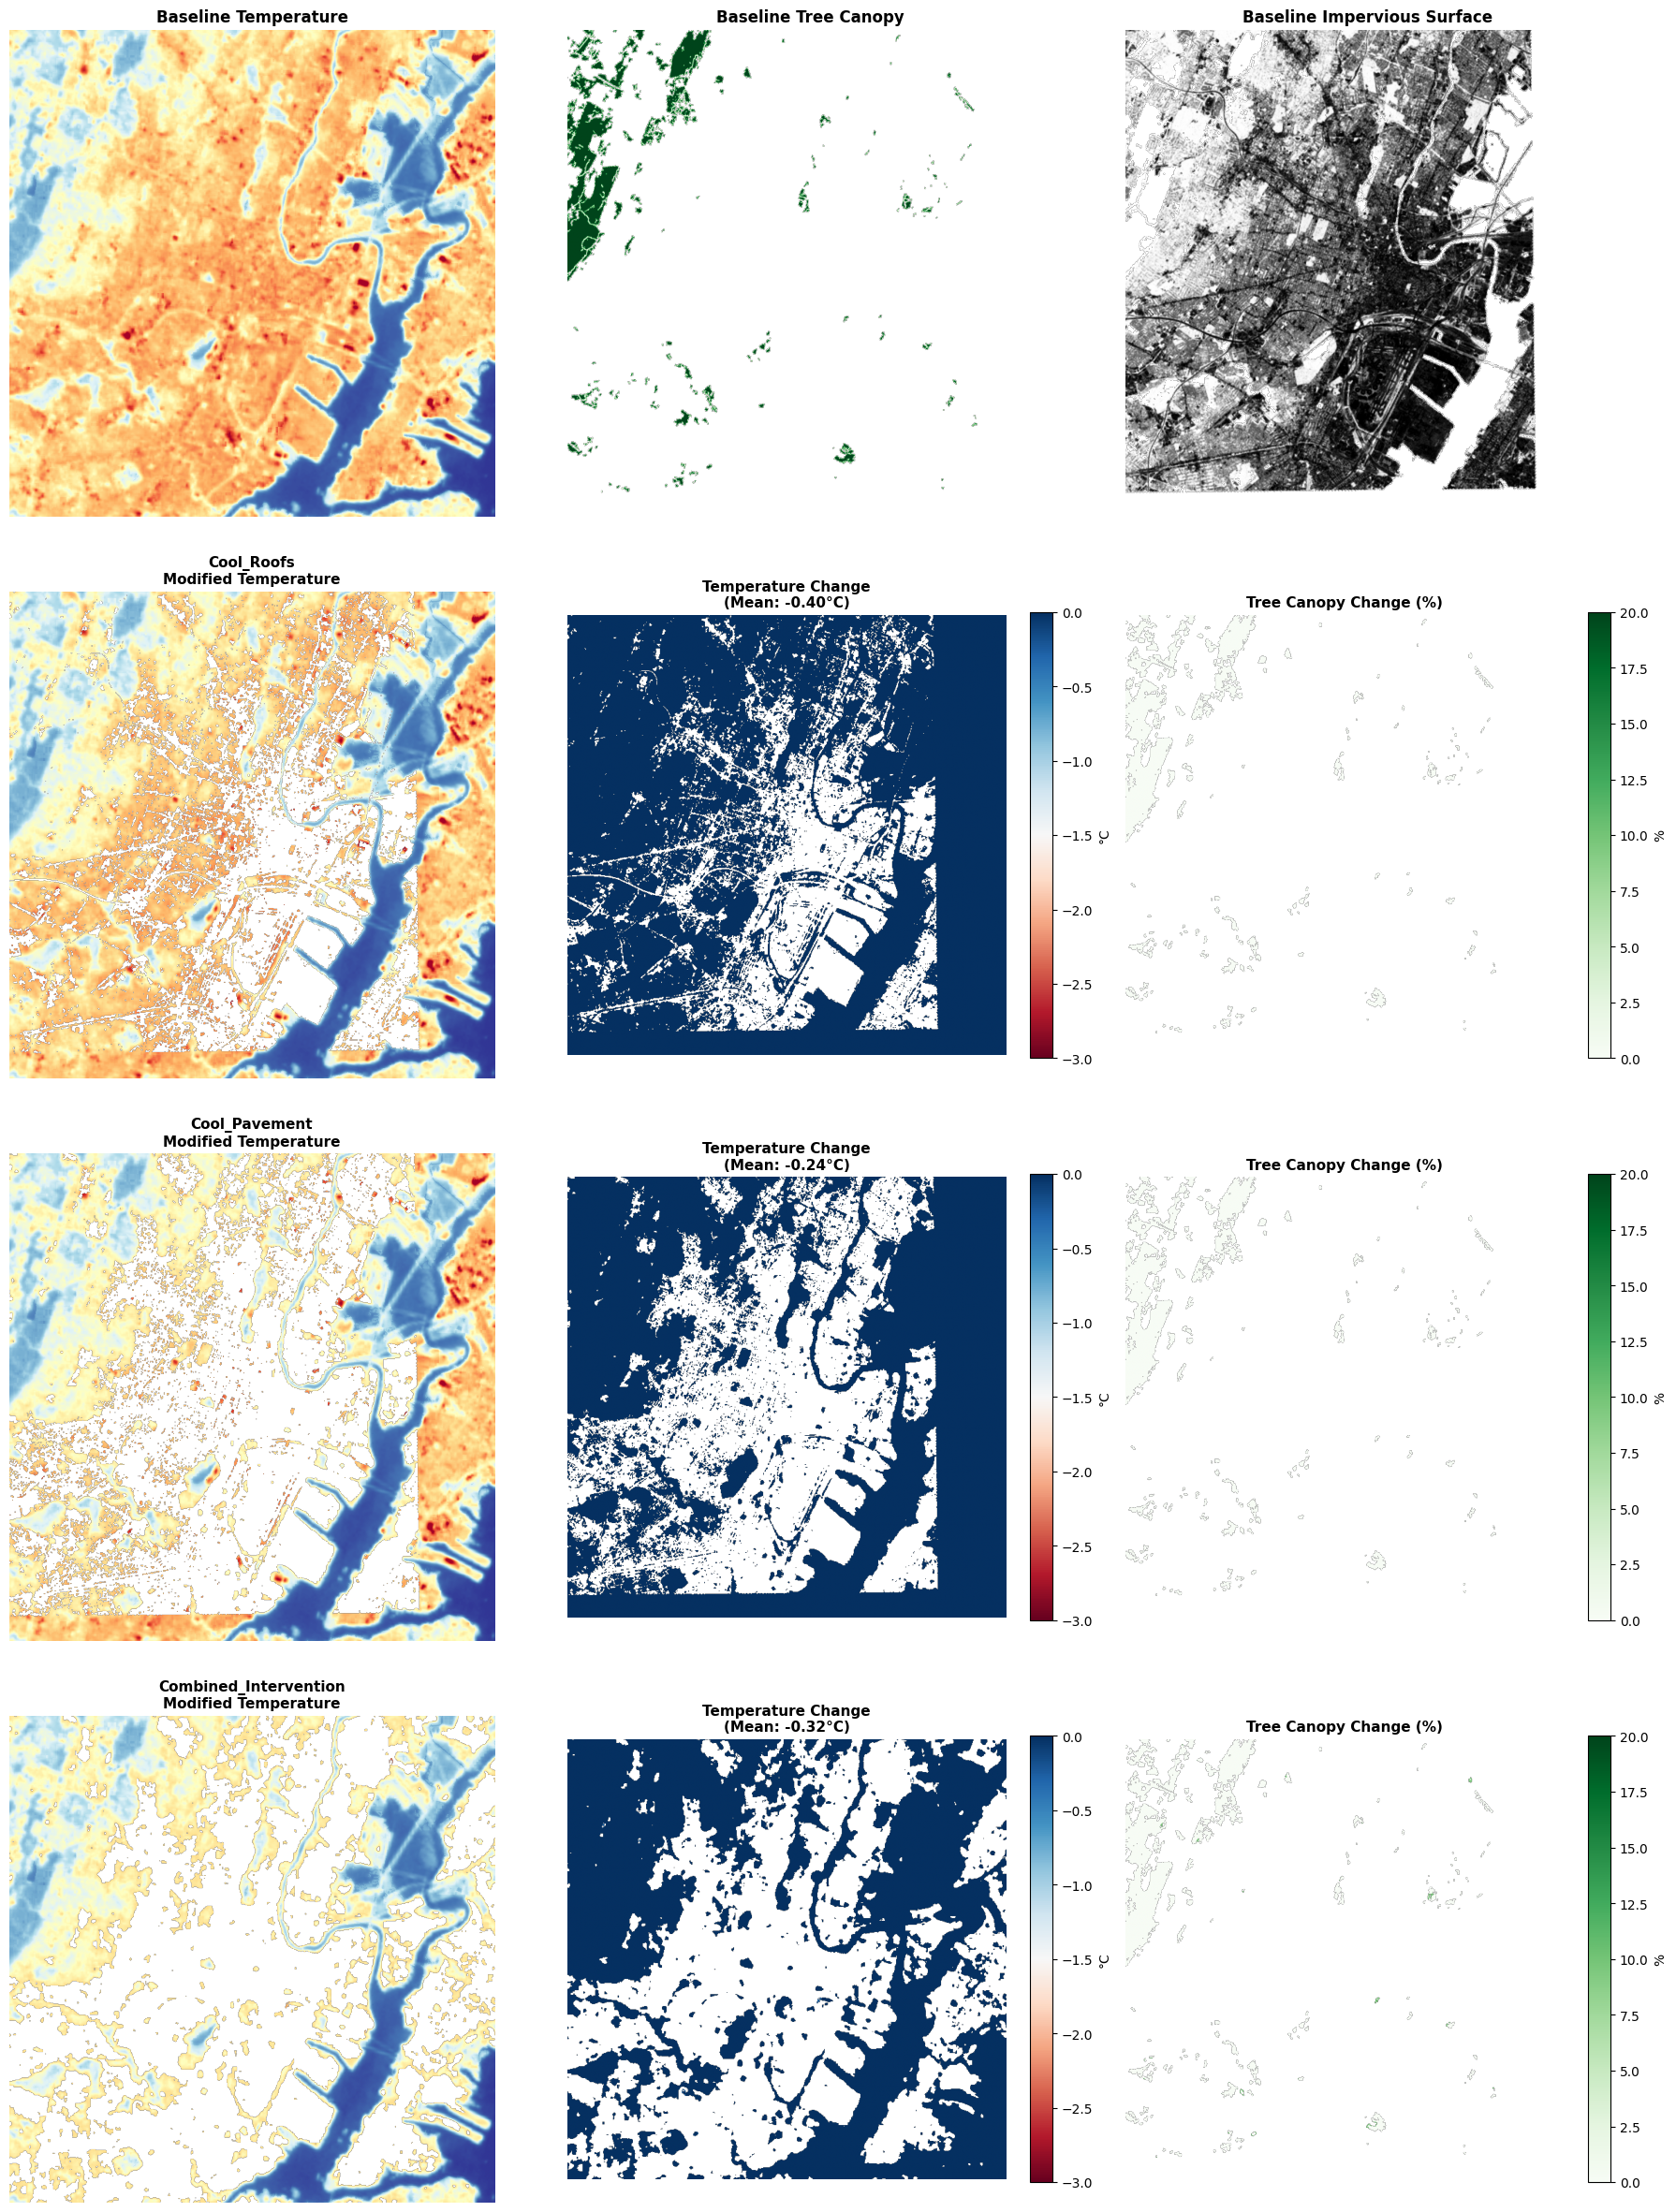

✓ Saved: Intervention_Cost_Effectiveness.png


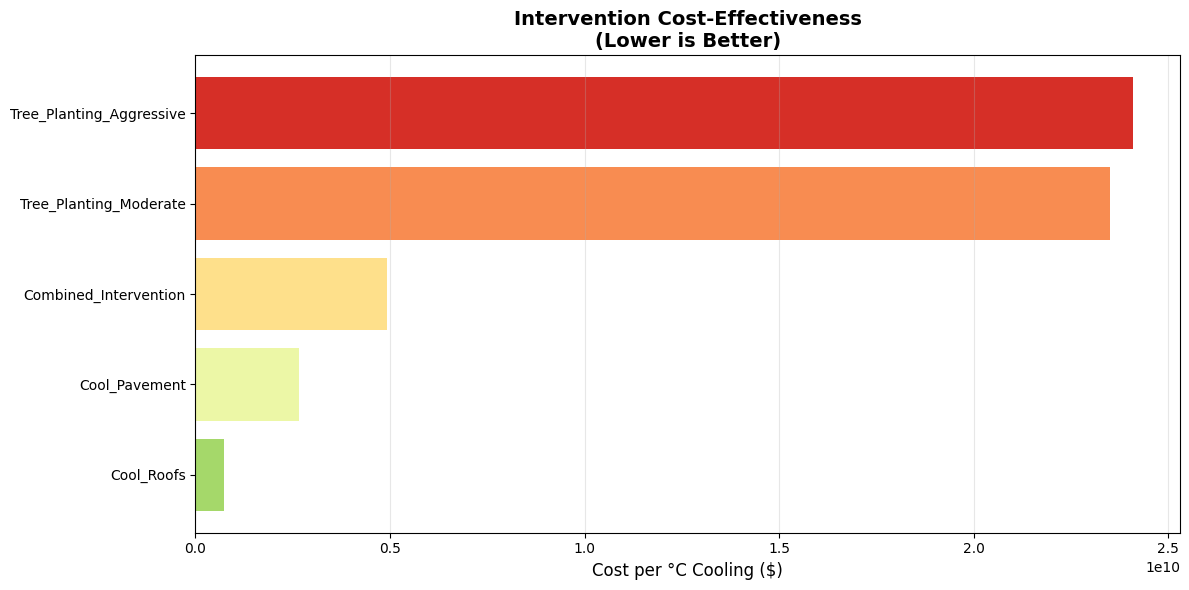

In [10]:
# ============================================
# STEP 6: VISUALIZATIONS
# ============================================
print("\n=== Creating Visualizations ===")

# Create comparison figure for top 3 scenarios
top_scenarios = summary_df.head(3)['Scenario'].tolist()

fig, axes = plt.subplots(len(top_scenarios) + 1, 3, figsize=(18, 6 * (len(top_scenarios) + 1)))

# Row 0: Baseline
axes[0, 0].imshow(lst_baseline, cmap='RdYlBu_r', vmin=20, vmax=50)
axes[0, 0].set_title('Baseline Temperature', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(tree_baseline, cmap='Greens', vmin=0, vmax=100)
axes[0, 1].set_title('Baseline Tree Canopy', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(impervious_baseline, cmap='Greys', vmin=0, vmax=100)
axes[0, 2].set_title('Baseline Impervious Surface', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Rows 1-3: Top scenarios
for i, scenario in enumerate(top_scenarios, start=1):
    result = simulation_results[scenario]

    # Temperature after intervention
    im1 = axes[i, 0].imshow(result['lst_modified'], cmap='RdYlBu_r', vmin=20, vmax=50)
    axes[i, 0].set_title(f'{scenario}\nModified Temperature', fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')

    # Temperature change
    im2 = axes[i, 1].imshow(result['temp_change'], cmap='RdBu', vmin=-3, vmax=0)
    axes[i, 1].set_title(f'Temperature Change\n(Mean: {result["mean_cooling"]:.2f}°C)',
                        fontsize=11, fontweight='bold')
    axes[i, 1].axis('off')
    plt.colorbar(im2, ax=axes[i, 1], label='°C', fraction=0.046)

    # Modified land cover
    if 'tree_modified' in result:
        im3 = axes[i, 2].imshow(result['tree_modified'] - tree_baseline,
                               cmap='Greens', vmin=0, vmax=20)
        axes[i, 2].set_title('Tree Canopy Change (%)', fontsize=11, fontweight='bold')
    else:
        im3 = axes[i, 2].imshow(result['impervious_modified'] - impervious_baseline,
                               cmap='Greys_r', vmin=-10, vmax=0)
        axes[i, 2].set_title('Impervious Surface Change (%)', fontsize=11, fontweight='bold')

    axes[i, 2].axis('off')
    plt.colorbar(im3, ax=axes[i, 2], label='%', fraction=0.046)

plt.tight_layout()
plt.savefig('Intervention_Scenarios_Comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: Intervention_Scenarios_Comparison.png")
plt.show()

# Cost-effectiveness chart
fig, ax = plt.subplots(figsize=(12, 6))
summary_df_plot = summary_df.sort_values('Cost per °C ($)')
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(summary_df_plot)))
ax.barh(summary_df_plot['Scenario'], summary_df_plot['Cost per °C ($)'], color=colors)
ax.set_xlabel('Cost per °C Cooling ($)', fontsize=12)
ax.set_title('Intervention Cost-Effectiveness\n(Lower is Better)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('Intervention_Cost_Effectiveness.png', dpi=300, bbox_inches='tight')
print("✓ Saved: Intervention_Cost_Effectiveness.png")
plt.show()

In [11]:
# ============================================
# STEP 7: EXPORT RESULTS
# ============================================
print("\n=== Exporting Results ===")

output_folder = Path('08_Intervention_Results')
output_folder.mkdir(exist_ok=True)

# Save summary table
summary_df.to_csv(output_folder / 'Intervention_Summary.csv', index=False)
print("✓ Exported: Intervention_Summary.csv")

# Save modified rasters for top scenario
best_scenario = summary_df.iloc[0]['Scenario']
best_result = simulation_results[best_scenario]

export_profile = lst_profile.copy()
export_profile.update(dtype=rasterio.float32, nodata=-9999)

# Export modified LST
lst_export = np.where(np.isnan(best_result['lst_modified']), -9999, best_result['lst_modified'])
with rasterio.open(output_folder / f'{best_scenario}_Modified_LST.tif', 'w', **export_profile) as dst:
    dst.write(lst_export.astype(rasterio.float32), 1)
print(f"✓ Exported: {best_scenario}_Modified_LST.tif")

# Export temperature change
temp_change_export = np.where(np.isnan(best_result['temp_change']), -9999, best_result['temp_change'])
with rasterio.open(output_folder / f'{best_scenario}_Temperature_Change.tif', 'w', **export_profile) as dst:
    dst.write(temp_change_export.astype(rasterio.float32), 1)
print(f"✓ Exported: {best_scenario}_Temperature_Change.tif")



=== Exporting Results ===
✓ Exported: Intervention_Summary.csv
✓ Exported: Cool_Roofs_Modified_LST.tif
✓ Exported: Cool_Roofs_Temperature_Change.tif


In [12]:

# ============================================
# STEP 8: RECOMMENDATIONS
# ============================================
print("\n" + "="*60)
print("✅ INTERVENTION SIMULATION COMPLETE")
print("="*60)

best = summary_df.iloc[0]
print(f"\n🏆 MOST COST-EFFECTIVE INTERVENTION:")
print(f"  Scenario: {best['Scenario']}")
print(f"  {best['Description']}")
print(f"  Mean cooling: {best['Mean Cooling (°C)']:.2f}°C")
print(f"  Total cost: ${best['Total Cost ($)']:,.0f}")
print(f"  Cost per °C: ${best['Cost per °C ($)']:,.0f}")
print(f"  Population benefited: {best['Population Benefited']:,.0f}")

print(f"\n📋 TOP 3 RECOMMENDATIONS:")
for i, row in summary_df.head(3).iterrows():
    print(f"\n  {i+1}. {row['Scenario']}")
    print(f"     Cooling: {row['Mean Cooling (°C)']:.2f}°C")
    print(f"     Cost: ${row['Total Cost ($)']:,.0f}")
    print(f"     Area: {row['Area (km²)']:.2f} km²")

print(f"\n💡 IMPLEMENTATION STRATEGY:")
print(f"  Phase 1 (Year 1): {summary_df.iloc[0]['Scenario']}")
print(f"    - Focus on critical risk areas")
print(f"    - Estimated budget: ${summary_df.iloc[0]['Total Cost ($)']:,.0f}")
print(f"    - Expected cooling: {summary_df.iloc[0]['Mean Cooling (°C)']:.2f}°C")
print(f"\n  Phase 2 (Year 2-3): Expand to moderate risk areas")
print(f"  Phase 3 (Year 4-5): Comprehensive city-wide program")

print(f"\n📁 Outputs Created:")
print(f"  1. Intervention_Summary.csv")
print(f"  2. Intervention_Scenarios_Comparison.png")
print(f"  3. Intervention_Cost_Effectiveness.png")
print(f"  4. {best_scenario}_Modified_LST.tif")
print(f"  5. {best_scenario}_Temperature_Change.tif")

print(f"\n🔜 Next Steps:")
print(f"  1. Create interactive dashboard for scenario testing")
print(f"  2. Develop case studies for 2-3 neighborhoods")
print(f"  3. Present to stakeholders")

print("\n" + "="*60)
print("Team: Samuel Quansah, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,")
print("      Sai Charan Kumar Reddy Boggula")
print("Montclair State University - 2025")
print("="*60)


✅ INTERVENTION SIMULATION COMPLETE

🏆 MOST COST-EFFECTIVE INTERVENTION:
  Scenario: Cool_Roofs
  Convert 50% of roofs to reflective surfaces
  Mean cooling: -0.40°C
  Total cost: $295,790,400
  Cost per °C: $731,181,283
  Population benefited: 0

📋 TOP 3 RECOMMENDATIONS:

  3. Cool_Roofs
     Cooling: -0.40°C
     Cost: $295,790,400
     Area: 98.60 km²

  4. Cool_Pavement
     Cooling: -0.24°C
     Cost: $643,006,800
     Area: 160.75 km²

  5. Combined_Intervention
     Cooling: -0.32°C
     Cost: $1,599,480,000
     Area: 199.94 km²

💡 IMPLEMENTATION STRATEGY:
  Phase 1 (Year 1): Cool_Roofs
    - Focus on critical risk areas
    - Estimated budget: $295,790,400
    - Expected cooling: -0.40°C

  Phase 2 (Year 2-3): Expand to moderate risk areas
  Phase 3 (Year 4-5): Comprehensive city-wide program

📁 Outputs Created:
  1. Intervention_Summary.csv
  2. Intervention_Scenarios_Comparison.png
  3. Intervention_Cost_Effectiveness.png
  4. Cool_Roofs_Modified_LST.tif
  5. Cool_Roofs_Temp